In [1]:
%matplotlib inline

import numpy
import pandas
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:

#load the dataset
dataframe = pandas.read_csv("F:/UOSEST/Data/Lyle-pparg-ligand/input/pubchem_data/processed/pparg_ligand_data.txt", sep="\t")

not_ligand    762
ligand         34
Name: Type, dtype: int64

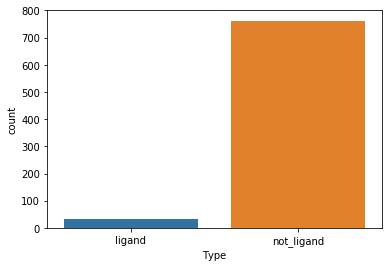

In [3]:
import seaborn as sns
d = dataframe
sns.countplot(d['Type'])
d['Type'].value_counts()

In [4]:
mols = []
fps = []

#get molecules and then get fingerprints from those
for index, row in dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    mols.append(mol)
    fps.append(fp)

#Convert the RDKit vectors into numpy arrays
#Based on: http://www.rdkit.org/docs/Cookbook.html#using-scikit-learn-with-rdkit
np_fps = []
for fp in fps:
    arr = numpy.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

#Need to encode my classes
#Ligand = 0, not_ligand = 1
encoder = LabelEncoder()
encoder.fit(dataframe['Type'])
enc_y = encoder.transform(dataframe['Type'])

In [5]:
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
def binary_focal_loss_fixed(y_true, y_pred):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    epsilon = K.epsilon()
    # clip to prevent NaN's and Inf's
    pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
    pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
           -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

return binary_focal_loss_fixed

<function __main__.async-def-wrapper.<locals>.binary_focal_loss_fixed(y_true, y_pred)>

In [28]:
#Create the machine learning model
from keras import optimizers
def create_deep_learning_model():
    model = Sequential()
    model.add(Dense(2048, input_dim=2048, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
from sklearn.utils import shuffle
tmp = [[x,y] for x, y in zip(np_fps_array, enc_y)]
tmp = shuffle(tmp)
X = [n[0] for n in tmp]
Y = [n[1] for n in tmp]

In [16]:
X= np.array(X)
Y= np.array(Y)

In [17]:
n = len(X)
p = 0.8
X_test = X[int(n*p):]
Y_test = Y[int(n*p):]

X_train = X[:int(n*p)]
Y_train = Y[:int(n*p)]

1    609
0     27
dtype: int64

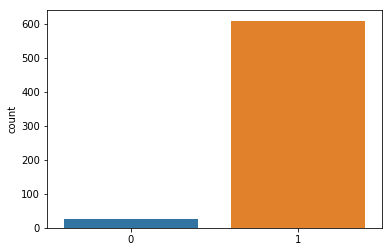

In [18]:
import seaborn as sns
sns.countplot(Y_train)
pandas.Series(Y_train).value_counts()

1    153
0      7
dtype: int64

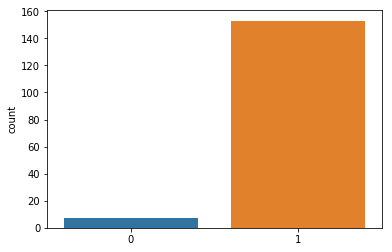

In [19]:
sns.countplot(Y_test)
pandas.Series(Y_test).value_counts()

In [29]:
class_weight={0:0.5, 1:1e-3}
estimator = KerasClassifier(build_fn=create_deep_learning_model,epochs=100, batch_size=10, class_weight =class_weight)
estimator.fit(X_train, Y_train,class_weight=class_weight)

ValueError: The model cannot be compiled because it has no loss to optimize.